# 1. Preparación de Entorno

In [1]:
from dotenv import load_dotenv
import os

# Carga las variables de entorno desde el archivo .env
load_dotenv()

bucket = "datasetsbdajac"

#Utilitario para manipular los servicios de AWS
import boto3

In [2]:
access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')
region = os.getenv('AWS_DEFAULT_REGION')

# 2. Conexión al servicio

In [3]:
#Obtenemos el cliente de servicio
rekognition = boto3.client(
  "rekognition", #Servicio al que nos conectamos
  aws_access_key_id = access_key_id, #Identificador de la clave
  aws_secret_access_key = secret_access_key, #Contraseña de la clave
  region_name = region #Región de la clave
)

# 3. Envío de consulta

In [4]:
#Enviamos la consulta
#Es una consulta asíncrona
respuesta = rekognition.detect_labels(
    Image = { #Indicamos la imagen
        "S3Object": { #Físicamente, la imagen se encuentra en S3
            "Bucket": bucket, #Bucket de la imagen, CAMBIAR "XXX" por nuestras iniciales
            "Name": "imagenes/IMAGEN_2.jpg" #Ruta de la imagen
        }
    },
    MaxLabels = 10 #Cantidad máxima de entidades que queremos detectar
)

# 4. Descarga de archivos necesarios

In [5]:
#Obtenemos el cliente de servicio
s3 = boto3.client(
  "s3", #Servicio al que nos conectamos
  aws_access_key_id = access_key_id, #Identificador de la clave
  aws_secret_access_key = secret_access_key, #Contraseña de la clave
  region_name = region #Región de la clave
)

#Descargamos el archivo de imagen
s3.download_file(
  bucket,
  "imagenes/IMAGEN_2.jpg",
  "./content/IMAGEN_2.jpg"
)

#Descargamos el archivo de fuentes de texto para escribir sobre la imagen
s3.download_file(
  bucket,
  "imagenes/arial.ttf",
  "./content/arial.ttf"
)

# 5. Dibujado de Bounding Box

In [13]:
#Utilitario para recibir contenido binario proveniente de una imagen
from PIL import Image

In [14]:
#Abrimos la imagen original
imagenOriginal = Image.open("./content/IMAGEN_2.jpg")

In [15]:
#Obtiene las dimensiones de la imagen
width, height = imagenOriginal.size

#Verificamos
width, height

(1380, 920)

In [16]:
#Utilitario para cargar fuentes de texto
from PIL import ImageFont

In [17]:
#Definimos la fuente y tamaño de texto que usaremos para escribir la descripción del objeto sobre la imagen
fuente = ImageFont.FreeTypeFont("./content/arial.ttf", size = 40)

In [18]:
#Utilitario para editar imágenes
from PIL import ImageDraw

In [19]:
#Instanciamos un objeto que pueda editar y dibujar sobre la imagen
dibujador = ImageDraw.Draw(imagenOriginal)

In [20]:
#Iteramos cada línea
for analisis in respuesta["Labels"]:

  #Filtramos sólo los objetos
  if len(analisis["Instances"]) > 0:

    #Iteramos cada objeto 
    for objeto in analisis["Instances"]:
      #Des-normalizamos desnormalizar 
      x = int(objeto["BoundingBox"]["Left"] * width)
      y = int(objeto["BoundingBox"]["Top"] * height)
      w = int(objeto["BoundingBox"]["Width"] * width)
      h = int(objeto["BoundingBox"]["Height"] * height)
      
      
      #Le decimos al "dibujador" que dibuje un rectángulo sobre la imagen según el "x, y, w, h" del objeto que estamos iterando
      dibujador.rectangle(
          [ #Indicamos en qué posiciones dibujar el rectángulo
              x, #Desde el pixel "x"
              y, #Desde el pixel "y"
              x + w, #Hasta el pixel "x + w"
              y + h  #Hasta el pixel "y + h"
          ],
          outline = "red", #Color del borde del rectángulo
          width = 4 #Ancho de línea del rectángulo
      )

      #Le decimos al "dibujador" que coloque la descripción del objeto encima del rectángulo
      dibujador.text(
          [ #Indicamos la posición "x, y" en donde colocamos el cuadro de texto
              x, #Desde el pixel "x"
              y - 40, #Colocamos el texto unos pixeles más arriba del cuadro de texto
          ],
          str(analisis["Name"]), #Texto que se coloca (descripción del objeto)
          fill = "red", #Color del texto
          font = fuente #Fuente y tamaño del texto
      )

In [21]:
#Guardamos la imagen original con las modificaciones que hizo el "dibujador"
imagenOriginal.save("./content/objetos_bounding_boxes.jpg")

In [22]:
#Cerramos el archivo de imagen
imagenOriginal.close()

# 6. Verificación visual

In [23]:
#Importamos el utilitario que nos permite visualizar imágenes
import IPython.display as visual

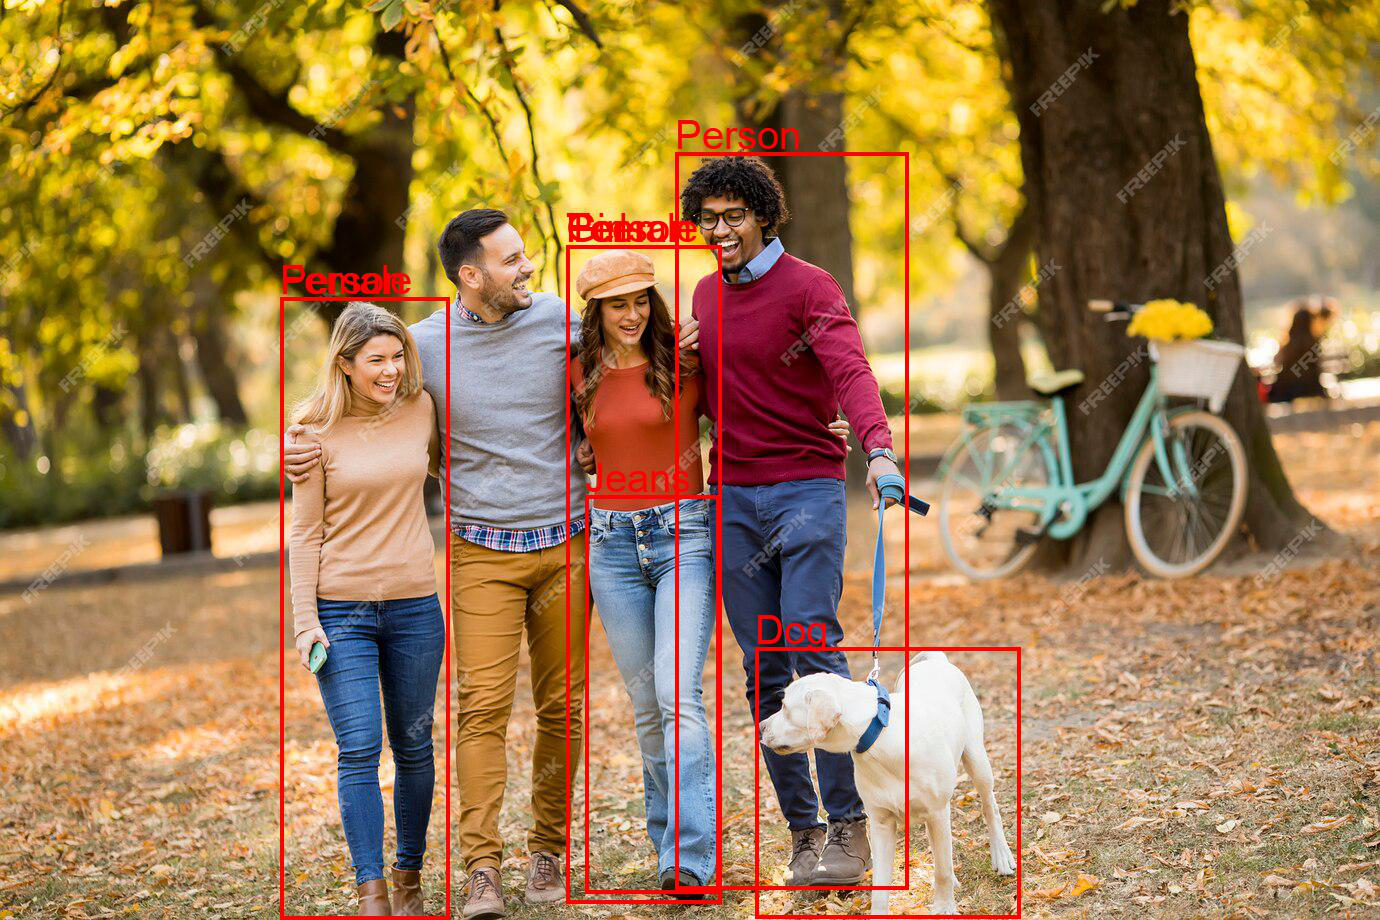

In [24]:
#Visualizamos la imagen
visual.display(
  Image.open("./content/objetos_bounding_boxes.jpg") #Abrimos la imagen
)

# 7. Almacenamiento de la imagen

In [26]:
#Obtenemos el cliente de servicio
s3 = boto3.client(
  "s3", #Servicio al que nos conectamos
  aws_access_key_id = access_key_id, #Identificador de la clave
  aws_secret_access_key = secret_access_key, #Contraseña de la clave
  region_name = region #Región de la clave
)

#Subimos el archivo a AWS
s3.upload_file(
  "./content/objetos_bounding_boxes.jpg",
  bucket,
  "output/objetos_bounding_boxes.jpg"
)

#Verificamos desde el portal de AWS